Current directory: C:\Users\pbenko\Documents\20250213_distribution_data_python\data\criteria_protocol
CSV file saved to: flagged_data_rearranged.csv


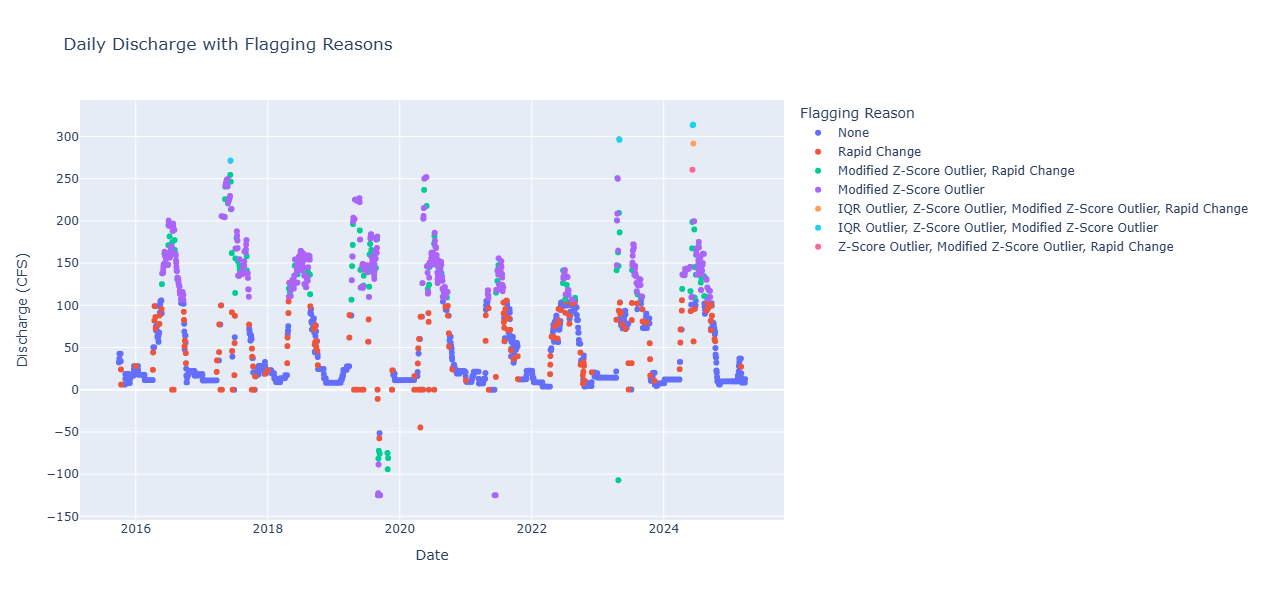

176.8


In [14]:
import requests
import re
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
from io import StringIO
from datetime import date
from scipy.stats import zscore
import os

# Ensure the Plotly renderer is set to JupyterLab
pio.renderers.default = 'jupyterlab'

# Define the UTDWR site ID
site_id = "10987"

# Get the current year
today = date.today()
current_year = int(today.strftime("%Y"))
start_year = 1990  # Adjust as needed

# Initialize an empty dataframe to store all years
df_all_years = pd.DataFrame()

for year in range(start_year, current_year + 1):  # Loop over years
    try:
        # Construct the URL
        URL = f"https://www.waterrights.utah.gov/cgi-bin/dvrtview.exe?STATION_ID={site_id}&RECORD_YEAR={year}&Modinfo=Daily_Comma"
        
        rr = requests.get(URL)
        temp = StringIO(rr.text)
        lines = temp.readlines()
        
        # Extract the actual data URL
        URL_end = next((re.findall('"([^"]*)"', line)[0] for line in lines if line.startswith("Daily comma delimited")), None)
        
        if not URL_end:
            continue  # Skip if no valid URL
        
        URL_full = f"https://www.waterrights.utah.gov{URL_end}"
        rrr = requests.get(URL_full)
        
        df = pd.read_csv(StringIO(rrr.text))
        
        # Skip years with unexpected column counts
        if df.shape[1] != 4:
            continue

        # Rename columns properly
        df.columns = ["year", "month", "day", "DISCHARGE"]
        df["DATE"] = pd.to_datetime(df[['year', 'month', 'day']])
        df.drop(columns=["year", "month", "day"], inplace=True)

        df_all_years = pd.concat([df_all_years, df], ignore_index=True)
    
    except Exception:
        continue  # Skip errors silently

# Add 'STATION_ID' and 'RECORD_YEAR' columns before melting the dataframe
df_all_years['STATION_ID'] = site_id  # Assign site ID to all rows
df_all_years['RECORD_YEAR'] = df_all_years['DATE'].dt.year  # Assign the year from the 'DATE' column

# Compute rate of change (grouped by year)
df_all_years['Discharge_Change'] = df_all_years.groupby('RECORD_YEAR')['DISCHARGE'].diff()

# ------------------------------------------------------
# Outlier Detection Techniques

# 1. IQR method for outlier detection
Q1 = df_all_years['DISCHARGE'].quantile(0.25)
Q3 = df_all_years['DISCHARGE'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold_lower = Q1 - 1.5 * IQR
outlier_threshold_upper = Q3 + 1.5 * IQR

# Flag outliers using IQR
df_all_years['OUTLIER_IQR'] = (df_all_years['DISCHARGE'] < outlier_threshold_lower) | (df_all_years['DISCHARGE'] > outlier_threshold_upper)

# 2. Z-Score method for outlier detection
df_all_years['Z_SCORE'] = zscore(df_all_years['DISCHARGE'], nan_policy='omit')
df_all_years['OUTLIER_Z'] = (df_all_years['Z_SCORE'].abs() > 3)

# 3. Modified Z-Score (using Median Absolute Deviation)
median = df_all_years['DISCHARGE'].median()
mad = np.median(np.abs(df_all_years['DISCHARGE'] - median))
df_all_years['MOD_Z_SCORE'] = 0.6745 * (df_all_years['DISCHARGE'] - median) / mad
df_all_years['OUTLIER_MOD_Z'] = df_all_years['MOD_Z_SCORE'].abs() > 3  # Threshold of 3.5 for modified Z-score

# 1. Differencing: Check if change exceeds 95th percentile
roc_95th_percentile = np.percentile(df_all_years['Discharge_Change'].dropna(), 95)
df_all_years['RAPID_CHANGE_DIFF'] = df_all_years['Discharge_Change'].abs() > roc_95th_percentile

# ------------------------------------------------------
# Combine all flags for outliers and create flagging reason column
df_all_years['FLAGGED'] = (
    df_all_years['OUTLIER_IQR'] |
    df_all_years['OUTLIER_Z'] |
    df_all_years['OUTLIER_MOD_Z'] |
    df_all_years['RAPID_CHANGE_DIFF']
)

# Assign flagging reasons based on conditions
def get_flag_reason(row):
    reasons = []
    if row['OUTLIER_IQR']:
        reasons.append('IQR Outlier')
    if row['OUTLIER_Z']:
        reasons.append('Z-Score Outlier')
    if row['OUTLIER_MOD_Z']:
        reasons.append('Modified Z-Score Outlier')
    if row['RAPID_CHANGE_DIFF']:
        reasons.append('Rapid Change')
    return ', '.join(reasons) if reasons else 'None'

df_all_years['Flag_Reason'] = df_all_years.apply(get_flag_reason, axis=1)

# ------------------------------------------------------
# Ensure the 'Date' column is formatted correctly before saving
df_all_years['Date'] = pd.to_datetime(df_all_years['DATE'], errors='coerce')

# Drop rows with invalid or missing dates
df_all_years = df_all_years.dropna(subset=['Date'])

# Print current directory
print(f"Current directory: {os.getcwd()}")

# Save flagged data to CSV
output_path = "flagged_data_rearranged.csv"  # Adjust path as needed
df_all_years[df_all_years['FLAGGED']].to_csv(output_path, index=False)
print(f"CSV file saved to: {output_path}")

# ------------------------------------------------------
# Create an interactive plot
# Use 'DISCHARGE' for y-axis and 'Flag_Reason' for color
fig = px.scatter(
    df_all_years, 
    x='Date', 
    y='DISCHARGE', 
    color='Flag_Reason',  # Color points by flagging reason
    title="Daily Discharge with Flagging Reasons",
    labels={'DISCHARGE': 'Discharge (CFS)', 'Date': 'Date'},
    category_orders={'Flag_Reason': df_all_years['Flag_Reason'].unique().tolist()}  # Ensure all flag reasons are in the legend
)

# Update the layout to enhance the appearance
fig.update_layout(
    legend_title="Flagging Reason",
    width=1200,
    height=600
)

# Show the plot in JupyterLab
fig.show()

# Assuming df_all_years is your dataframe
discharge_95th_percentile = np.percentile(df_all_years['DISCHARGE'].dropna(), 95)
print(discharge_95th_percentile)